In [1]:
import pickle;
import numpy as np;
from numpy.linalg import pinv;
from numpy.polynomial.legendre import legvander;
import tensorflow as tf

import control
import os; 
from __future__ import division


In [2]:

file_obj = file('/Users/yeun026/Documents/darpa-sd2/deepDMD/koopman_scalers/MD_scaler.pickle','rb');
all_scalers = pickle.load(file_obj);
u_scaler = all_scalers[0];
y_scaler = all_scalers[1];

file_obj.close()





In [3]:
sess = tf.InteractiveSession();
saver = tf.train.import_meta_graph('/Users/yeun026/Documents/darpa-sd2/deepDMD/MD.pickle.ckpt.meta')
saver.restore(sess,tf.train.latest_checkpoint('/Users/yeun026/Documents/darpa-sd2/deepDMD/'));


def gen_psix_lifting(x_curr):
    
    x_curr = np.reshape(x_curr,(1,np.max(x_curr.shape)));
    if np.sum(np.abs(x_curr))>0:
        x_curr_scaled = y_scaler.transform(x_curr);
    else:
        x_curr_scaled = x_curr;
    with_control = 1;
        
    psiyp = tf.get_collection('psiyp')[0];
    psiyf = tf.get_collection('psiyf')[0];
    #psiu = tf.get_collection('psiu')[0];
    yp_feed = tf.get_collection('yp_feed')[0];
    yf_feed = tf.get_collection('yf_feed')[0];
    #u_control = tf.get_collection('u_control')[0];
    #print x_curr.shape;
    x_curr_scaled = x_curr_scaled.squeeze();
    #u_curr = u_curr.squeeze(); 

    psi_lifting = psiyf.eval(feed_dict={yf_feed:[x_curr_scaled]});
    #psi_u_lifting = psiu.eval(feed_dict={u_control:[u_curr]});
    #print psi_lifting
    return psi_lifting;


def gen_psiu_lifting(u_curr):
    
    
    
    u_curr = np.reshape(u_curr,(1,np.max(u_curr.shape)));
    if np.sum(np.abs(u_curr))>0:
        u_curr_scaled = u_scaler.transform(u_curr);
    else:
        u_curr_scaled = u_curr;
    
    
    ### TF variables. 
    psiu = tf.get_collection('psiu')[0];
    u_control = tf.get_collection('u_control')[0];
    ### TF variables. 
    
    u_curr_scaled = u_curr_scaled.squeeze(); 

    psi_u_lifting = psiu.eval(feed_dict={u_control:[u_curr_scaled]});
    return psi_u_lifting;

def gen_psiu_lifting_direct(u_curr):
    
    
    ### TF variables. 
    psiu = tf.get_collection('psiu')[0];
    u_control = tf.get_collection('u_control')[0];
    ### TF variables. 
    
    u_curr = u_curr.squeeze(); 

    psi_u_lifting = psiu.eval(feed_dict={u_control:[u_curr]});
    return psi_u_lifting;


def gen_psix_lifting_direct(x_curr):
        
    psiyp = tf.get_collection('psiyp')[0];
    psiyf = tf.get_collection('psiyf')[0];
    
    yp_feed = tf.get_collection('yp_feed')[0];
    yf_feed = tf.get_collection('yf_feed')[0];
    
    psi_lifting = psiyf.eval(feed_dict={yf_feed:x_curr.T});
    return psi_lifting;



def load_matrices():
    file_obj = file('/Users/yeun026/Documents/darpa-sd2/deepDMD/h2synthesis/controller_matrices.pickle','rb');
    all_matrices = pickle.load(file_obj);
    Av = all_matrices[0];
    Bv = all_matrices[1];
    Cv = all_matrices[2]; 
    return Av,Bv, Cv;

import scipy.io
def load_continuous_matrices():
    mdict = scipy.io.loadmat('/Users/yeun026/Documents/darpa-sd2/deepDMD/h2synthesis/continuous_controller_matrices.mat') #Av,Bv,Cv
    print mdict.keys()
    print type(mdict['Ac']);
    #file_obj = file('/Users/yeun026/Documents/darpa-sd2/deepDMD/h2synthesis/controller_matrices.pickle','rb');
    #all_matrices = pickle.load(file_obj);
    Av = mdict['Ac'];
    Bv = mdict['Bc'];
    Cv = mdict['Cc'];
    return Av,Bv,Cv;

In [27]:
import numpy as np 
import math
from scipy import integrate
#import required libraries for reading excel
from openpyxl import load_workbook

n_inputs = 5;    
with_KoopControl = True;   
care_active = False;
scaled = False;
#read  from excel file
wb = load_workbook('data_NewEngland.xlsx')
sheet_1 = wb.get_sheet_by_name('bus')
bus = np.zeros((sheet_1.max_row,sheet_1.max_column))
 
for i in range(0,sheet_1.max_row):
    for j in range(0,sheet_1.max_column):
        bus[i,j]=sheet_1.cell(row=i+1, column=j+1).value

sheet_2 = wb.get_sheet_by_name('line')
line = np.zeros((sheet_2.max_row,sheet_2.max_column))
 
for i in range(0,sheet_2.max_row):
    for j in range(0,sheet_2.max_column):
        line[i,j]=sheet_2.cell(row=i+1, column=j+1).value

sheet_3 = wb.get_sheet_by_name('exc_con')
exc_con = np.zeros((sheet_3.max_row,sheet_3.max_column))
 
for i in range(0,sheet_3.max_row):
    for j in range(0,sheet_3.max_column):
        exc_con[i,j]=sheet_3.cell(row=i+1, column=j+1).value

sheet_4 = wb.get_sheet_by_name('ibus_con')
ibus_con = np.zeros((sheet_4.max_row,sheet_4.max_column))
 
for i in range(0,sheet_4.max_row):
    for j in range(0,sheet_4.max_column):
        ibus_con[i,j]=sheet_4.cell(row=i+1, column=j+1).value

sheet_5 = wb.get_sheet_by_name('mac_con')
mac_con = np.zeros((sheet_5.max_row,sheet_5.max_column))
 
for i in range(0,sheet_5.max_row):
    for j in range(0,sheet_5.max_column):
        mac_con[i,j]=sheet_5.cell(row=i+1, column=j+1).value

sheet_6 = wb.get_sheet_by_name('sw_con')
sw_con = np.zeros((sheet_6.max_row,sheet_6.max_column))
 
for i in range(0,sheet_6.max_row):
    for j in range(0,sheet_6.max_column):
        sw_con[i,j]=sheet_6.cell(row=i+1, column=j+1).value

sheet_7 = wb.get_sheet_by_name('bus_sol')
bus_sol = np.zeros((sheet_7.max_row,sheet_7.max_column))
 
for i in range(0,sheet_7.max_row):
    for j in range(0,sheet_7.max_column):
        bus_sol[i,j]=sheet_7.cell(row=i+1, column=j+1).value

sheet_8 = wb.get_sheet_by_name('line_flow')
line_flow = np.zeros((sheet_8.max_row,sheet_8.max_column))
 
for i in range(0,sheet_8.max_row):
    for j in range(0,sheet_8.max_column):
        line_flow[i,j]=sheet_8.cell(row=i+1, column=j+1).value

sheet_9 = wb.get_sheet_by_name('theta_orig')
theta_orig = np.zeros((sheet_9.max_row,sheet_9.max_column))
 
for i in range(0,sheet_9.max_row):
    for j in range(0,sheet_9.max_column):
        theta_orig[i,j]=sheet_9.cell(row=i+1, column=j+1).value

# finished loading data from New England

global k_control
basmva = 100.0
n = bus.shape[0]    
m = line.shape[0]  

G = mac_con[:,1]
G = G.astype(int)
g = G.shape[0]
L = np.arange(1,n-g+1)
l = n-g;

Vm_orig = bus_sol[:,1]
Vm_orig=Vm_orig.astype(float)
theta_orig = bus_sol[:,2]/180.0*math.pi

Pm_orig= bus_sol[:,3]-bus_sol[:,5]
Pm_orig=Pm_orig.astype(float)
M = np.zeros((n,n))
M[np.ix_(G-1,G-1)] = np.diag(np.multiply((2*mac_con[:,15])/(2*math.pi*60),mac_con[:,2])/basmva)
M=M.astype(float)

D=np.zeros((n,n))
D[np.ix_(G-1,G-1)] = (5.0*np.diag(bus_sol[G-1,3])/(120*math.pi))
D[np.ix_(L-1,L-1)] = 0.2*np.mean((D[G-1,G-1]))*np.identity(l)
D=D*2.0
D=D*3.0
D=D.astype(float)
Tg = 0.2*np.ones((g,1))
Tb = 7.0*np.ones((g,1))
R = 1*0.05*np.divide((2.0*math.pi*60.0),bus_sol[G-1,3])
R=R.astype(float)

L_controlled=np.array([25,26])
Td=5.0*np.ones((n,1))

Bij = np.zeros((m,1))
Bij_nonlinear = np.zeros((m,1))
Bij_vf=np.zeros((m,1))
Plink_orig = np.zeros((m,1))
C= np.zeros((n,m))    # maintains float precision 
CQ= np.zeros((n,m))   
for k in range(m):
    ixp = int(line[k,0])-1
    ixn = int(line[k,1])-1
    C[ixp,k] = 1  # this op still maintains float precision 
    C[ixn,k] = -1 # this op still maintains float precision 
    CQ[ixp,k] = 1 # this op still maintains float precision 
    CQ[ixn,k] = 1 # this op still maintains float precision 
    Bij[k]=Vm_orig[ixp]*Vm_orig[ixn]/(line[k,3]) *np.cos(theta_orig[ixp]-theta_orig[ixn])
    Bij_nonlinear[k]=Vm_orig[ixp]*Vm_orig[ixn]/(line[k,3])
    Bij_vf[k]=1.0/line[k,3]
    Plink_orig[k] = Bij_nonlinear[k]*np.sin(theta_orig[ixp]-theta_orig[ixn])
    
Bij=Bij.astype(float)
Bjj=-bus[:,8];
Bjj=Bjj.astype(float)
for cnt1 in range(n):
    for cnt2 in range(m):
        if C[cnt1,cnt2] != 0:
            Bjj[cnt1]= Bjj[cnt1]-Bij_vf[cnt2]
        
Tv = mac_con[:,8]
Tv.astype(float)
xd = mac_con[:,5]
xd = xd.astype(float)
xdt= mac_con[:,6]
xdt = xdt.astype(float)

Ef=1.0

G_controlled = np.array([ 1, 3, 5  ])
cost_alpha = bus_sol[G-1,3]
bus_controlled = mac_con[G_controlled-1,1]
bus_controlled = bus_controlled.astype(int)


/Users/yeun026/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
  del sys.path[0]
/Users/yeun026/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
/Users/yeun026/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
/Users/yeun026/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
/Users/yeun026/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Call to deprecated function get_sheet_by_name (Use wb[sheetname]).
/Users/yeun026/Library/Python/2.7/lib/python/site-packages/ipykernel_launcher.py:48: DeprecationWarning: Call to deprecate

In [5]:
price_signal=0*np.random.rand(G_controlled.shape[0]+L_controlled.shape[0],1)*8.0-16.0
#price_signal = 0.0*price_signal;

In [29]:
limitlink=np.array([4, 19, 26])

barP = 10.0*np.ones((m,1))
barP[limitlink-1]= 3.0
underP = -barP
barDeltaP = barP - Plink_orig
underDeltaP = underP - Plink_orig

rm=np.transpose(np.arange(2,n+1))
rm=rm.astype(int)
Ct=C[rm-1,:]
needed = np.arange(1,l)
Lt=L[needed]-1

Bij = Bij.ravel()
H2 = np.matmul(Ct,np.diag(Bij))
H0 = np.linalg.inv(np.matmul(H2,np.transpose(Ct)))
H1 = np.matmul(np.transpose(Ct), H0)

H=np.transpose(np.matmul(np.diag(Bij),H1))
Hg=H[G-2,:]
Hl=H[Lt-1,:]

dtb=30
deltaPm=np.zeros((n,1));
deltaPm[dtb-1]=0.0; 

Tmax=20

omegao = np.zeros((g,1))
thetao = np.zeros((n,1))
#valveo = np.zeros((g,1))   
thetao[:,0] = theta_orig
pmecho = np.zeros((g,1))   
loado  = np.zeros((n,1))

PF = cost_alpha[G_controlled-1]/np.sum(cost_alpha[G_controlled-1])
PFd=np.sort(PF)
PFd=PFd[0:2]
PFd=-(PFd+0.02)
lambdao = np.zeros((1,1))
rhopo=np.zeros((m,1))
rhomo=np.zeros((m,1))
Eo = np.zeros((n,1))
Eo[:,0]=Vm_orig

if with_KoopControl:
    psiuo = np.zeros((Bv.shape[0],1));
    x0 = np.concatenate((omegao,thetao,pmecho,loado,Eo,psiuo),axis=0)
    #x0 = np.concatenate((omegao,thetao,valveo,pmecho,loado,Eo,psiuo),axis=0)
else:
    x0 = np.concatenate((omegao,thetao,pmecho,loado,Eo),axis=0)
    #x0 = np.concatenate((omegao,thetao,valveo,pmecho,loado,Eo),axis=0)




#price_signal=np.ones((G_controlled.shape[0]+L_controlled.shape[0],1))*80.0-40.0
pricefull=np.zeros((n,1))
price_sup=np.zeros((n,1))
price_sup[np.concatenate((np.transpose(bus_controlled-1) , L_controlled-1),axis=0)]=-8.0*np.ones((5,1))
gain=500.0
beta0 = 0.0;

In [30]:
def calculate_gains_matrix():
    #sess = tf.InteractiveSession();

    #saver = tf.train.import_meta_graph('/Users/yeun026/Documents/darpa-sd2/deepDMD/MD.pickle.ckpt.meta')
    #saver.restore(sess,tf.train.latest_checkpoint('/Users/yeun026/Documents/darpa-sd2/deepDMD/.'));
    
    #Kx = tf.get_collection('Kx')[0];
    #Ku = tf.get_collection('Ku')[0];
    #Kx_num = sess.run(Kx);
    #Ku_num = sess.run(Ku);
    #A = np.transpose(Kx_num); # Kx_num and Ku_num were defined using row multi. 
    #B = np.transpose(Ku_num);
    
    mdict = scipy.io.loadmat('/Users/yeun026/Documents/darpa-sd2/deepDMD/h2synthesis/continuous_controller_matrices.mat') #Av,Bv,Cv 
    A = mdict['Ac'];
    B = mdict['Bc'];
    C = mdict['Cc'];
    #print A.shape
    Q = 1e1*np.eye(A.shape[0]);
    R = 9.0e-3*np.eye(B.shape[1]);
    
    
    #Q = 1e1*np.eye(A.shape[0]);
    #R = 4.7e-3*np.eye(B.shape[1]);
    (X,L,G) = control.care(A,B,Q,R) 
    K_cand = np.matmul(np.matmul(np.linalg.inv(R),B.T),X)
    #s,v = np.linalg.eig(A+np.matmul(B,G))
    #print s
    
    return X,L,G;
Av,Bv,Cv = load_continuous_matrices();
X_sol,L_eig,G_gain = calculate_gains_matrix()
print G_gain


def md(t,x,n,m,deltaPm,barDeltaP,underDeltaP, M, D, C,Bij,  Bij_nonlinear,Plink_orig, R, Tg, Tb,Td, G, G_controlled,  L,L_controlled, PF,PFd, H, Hg, Hl, rm, Bjj, Tv, xd, xdt, Ef, Bij_vf,CQ,pricefull, bus_controlled,price_sup,gain):
    g = G.shape[0]
    global k_control
    k_control = 0.7*sum(1.0/R[G_controlled-1])
    k_lambda =1.0/np.mean((M[G-1,G-1]))*0.4
    k_rho = 25.0*0.5*np.identity(m)
    omegarange = range(g)
    thetarange = range(g,g+n)
    #valverange = range(n+g,n+g+g)
    pmechrange = range(n+1*g,n+1*g+g)
    loadrange = range(n+2*g,n+2*g+n)
    Erange = range(2*n+2*g,2*n+2*g+n)
    omega_g = x[omegarange]
    theta = x[thetarange]
    #valve = x[valverange]
    pmech = x[pmechrange]
    load = x[loadrange]
    E=x[Erange]
    if with_KoopControl:
        #print x.shape
        psiu = x[-1-Bv.shape[0]:-1]; 
        

    omega_g = x[omegarange]
    theta = x[thetarange]
    #valve = x[valverange]
    pmech = x[pmechrange]
    load = x[loadrange]
    E=x[Erange]
    edgev=np.ones((m,1));
    for cnt1 in range(m):
        for cnt2 in range(n):
            if C[cnt2,cnt1] !=0:
                edgev[cnt1]=edgev[cnt1]*E[cnt2]
    pgen = np.zeros((n,1)) 
    pmech = pmech.reshape((g,1))
    pgen[G-1] = pmech
    omega = np.zeros((n,1))
    omega[G-1] = omega_g.reshape((g,1))
    DS = D[np.ix_(L-1,L-1)]
    invDS = np.linalg.inv(DS)
    matrixX2 = np.matmul(np.diag(Bij_vf.ravel()),np.sin(np.matmul(np.transpose(C),theta)))
    matrixX2 = matrixX2.reshape((m,1))
    matrixX3 = np.multiply(edgev,matrixX2)
    Cp = C[np.ix_(L-1,range(m))]
    matrixX = np.matmul(Cp,(matrixX3 -Plink_orig))
    loadL = load[L-1].reshape(l,1)
    loadLC = load[L_controlled-1].reshape(L_controlled.shape[0],1)
    omega[L-1]  =  np.matmul(invDS,( pgen[L-1] + deltaPm[L-1] - loadL - matrixX))
    
    
    p_signal = np.zeros((g,1))
    
    ## EY Controller Code
    if with_KoopControl:
        
        delta_flow_r = matrixX3 -Plink_orig
        omega_g_r=omega_g.reshape(g,1)
        pmech_r=pmech.reshape(g,1)
        load_r=load.reshape(n,1)
        delta_flow_r=delta_flow_r.reshape(m,1) 
        curr_ol_state = omega_g_r;        
        #curr_ol_state = np.concatenate((omega_g_r,pmech_r,load_r,delta_flow_r),axis=0)        
        #print curr_ol_state.shape
        if scaled:
            psix_lifting = gen_psix_lifting(curr_ol_state)
            #print "psix_lifting.shape: " + repr(psix_lifting.shape);

            psiu_lifting = gen_psiu_lifting(psiu[0:n_inputs]);
            #print "psiu_lifting.shape: " + repr(psiu_lifting.shape);

            dpsiu_scaled = np.matmul(Av,psiu_lifting.T).T + np.matmul(Bv,psix_lifting.T).T ;

            #print " dpsiu_scaled.shape : " + repr(dpsiu_scaled.shape)
            #print dpsiu_scaled

            if np.sum(np.abs(dpsiu_scaled))>0:
                du_unscaled = u_scaler.inverse_transform(dpsiu_scaled[:,0:n_inputs]);
                dpsiu = gen_psiu_lifting_direct(du_unscaled);
            else:
                dpsiu = dpsiu_scaled;
        else:
            psix_lifting = gen_psix_lifting_direct(curr_ol_state)
            #print "psix_lifting.shape: " + repr(psix_lifting.shape);

            psiu_lifting = gen_psiu_lifting_direct(psiu[0:n_inputs]);
            #print "psiu_lifting.shape: " + repr(psiu_lifting.shape);

            dpsiu = np.matmul(Av,psiu_lifting.T).T + np.matmul(Bv,psix_lifting.T).T ;

        control_output = psiu;
        #print control_output.shape
            
    if care_active:
        omega_g_r=omega_g.reshape(g,1)
        curr_ol_state = omega_g_r;

        if scaled:
            psix_lifting_scaled = gen_psix_lifting(curr_ol_state)
            #print psix_lifting_scaled.shape
            dpsiu = 0.0; 
            control_output_scaled = np.matmul(1.0*G_gain.T,psix_lifting_scaled.T)
            #print control_output_scaled.shape
            if np.sum(np.abs(control_output_scaled))>0:
                control_output_unscaled =gen_psiu_lifting_direct(u_scaler.inverse_transform(control_output_scaled[0:n_inputs]));
                control_output = control_output_unscaled;
            else:
                control_output =control_output_scaled;
        else:
            psix_lifting = gen_psix_lifting_direct(curr_ol_state); 
            control_output = np.matmul(1.0*G_gain.T,psix_lifting.T);
    #print np.mean(np.abs(psiu_lifting))
        #print np.mean(np.abs(psiu));
        #print np.mean(np.abs(dpsiu));
        #print np.mean(np.abs(dpsiu_scaled)); 
        #if np.any(np.abs(control_output)>1e3): 
        #    print np.where(control_output>1e3);
        #    print control_output;
        
    pricefull[bus_controlled] = control_output[0:3].reshape((3,1));
    pricefull[L_controlled] = control_output[3:5].reshape((2,1));
    if t<1e-6:
        print control_output[0:5];
    a1 = k_control*PF
    a1 = a1.reshape(bus_controlled.shape[0],1)
    a2 = k_control*PFd
    a2 = a2.reshape(L_controlled.shape[0],1)
    
    
    #p_signal[G_controlled-1] = pricefull[bus_controlled] -  np.multiply(np.divide(1.0,(a1)), pmech[G_controlled-1])+ pmech[G_controlled]+  np.divide(gain*np.ones((bus_controlled.shape[0],1)),(price_sup[bus_controlled-1]-pricefull[bus_controlled-1] + beta0) )  
    p_signal[G_controlled-1] = pricefull[bus_controlled] -  np.multiply(np.divide(1.0,(a1)), pmech[G_controlled-1])+ pmech[G_controlled]+  price_sup[bus_controlled-1];  
    
    
    
    d_signal=np.zeros((n,1))
    #d_signal[L_controlled-1]= np.multiply(np.divide(1,(a2)), loadLC) -  pricefull[L_controlled-1]  +loadLC -  np.divide(gain*np.ones((L_controlled.shape[0],1)),(price_sup[L_controlled-1]-pricefull[L_controlled-1] + beta0))
    d_signal[L_controlled-1]= np.multiply(np.divide(1,(a2)), loadLC) -  pricefull[L_controlled-1]  +loadLC - price_sup[L_controlled-1]
    
    #if np.any(np.abs(d_signal[L_controlled-1])>1e3):
    #    print "Term 1: " + repr(np.multiply(np.divide(1,(a2)), loadLC));
    #    print  "Price full: " + repr(pricefull[L_controlled-1]);
    #    print "Spoofing term, quotient: " + repr(np.divide(gain*np.ones((L_controlled.shape[0],1)),(price_sup[L_controlled-1]-pricefull[L_controlled-1] + beta0)));
    loadG = load[G-1]
    loadG = loadG.reshape(g,1)
    a3 = np.matmul(np.diag(Bij_vf.ravel()),np.sin(np.matmul(np.transpose(C),theta)))
    a3 = a3.reshape(m,1)
    b2=np.matmul(C[np.ix_(G-1,range(m))],(np.multiply(edgev,a3) -Plink_orig))
    b3 = np.matmul(D[np.ix_(G-1,G-1)],omega_g)
    b3 = b3.reshape(g,1)
    domega_g  = np.matmul(np.linalg.inv(M[np.ix_(G-1,G-1)]),(deltaPm[G-1] + pgen[G-1] -loadG - b3 - b2));
    #print (deltaPm[G-1] + pgen[G-1] -loadG - b3 - b2);
    dtheta  = omega             
    #c1 = -valve.reshape(g,1) +p_signal
    #dvalve =  np.matmul(np.linalg.inv(np.diag(Tg.ravel())),(c1))
    #dpmech  = np.matmul(np.linalg.inv(np.diag(Tb.ravel())),(- pmech + valve.reshape(g,1)))
    dpmech  = np.matmul(np.linalg.inv(np.diag(Tb.ravel())),(- pmech + p_signal.reshape(g,1)))
    dload= np.matmul(np.linalg.inv(np.diag(Td.ravel())),(-load.reshape(n,1) + d_signal))
    #if np.any(np.abs(dload)>1e3):
    #    print d_signal # d_signal is the culprit 
        
    dlambda = k_lambda*( - np.sum(deltaPm) - np.sum(pgen) + np.sum(load) )
    dE=np.zeros((n,1))
    
    a41 = (1-np.multiply((xd-xdt),Bjj[G-1]))
    a41=a41.reshape(g,1)
    a4=np.multiply(a41,E[G-1].reshape((g,1)))
    #print a4.shape
    #print E[G-1].shape
    
    
    a7=np.matmul(np.diag(Bij_vf.ravel()),np.cos(np.matmul(np.transpose(C),theta)))
    a7 = a7.reshape(m,1)
    a6 = np.multiply(edgev,(a7))
    a5 = np.matmul(CQ[np.ix_(G-1,range(m))],(a6))
    a9 = xd-xdt
    a9 = a9.reshape(g,1)
    EG=E[G-1]
    EG=EG.reshape(g,1)
    a11 = np.divide((a5),EG)
    a8 = np.multiply(a9, a11)
    a12 = np.linalg.inv(np.diag(Tv.ravel()))
    #print a4.shape
    a13 = (Ef*np.ones((g,1))-a4 + a8)
    
    #print a12.shape
    #print a13.shape
    dE[G-1]=np.matmul(a12,a13)
    if with_KoopControl:
        #print dpsiu.shape
        dpsiu_r = dpsiu.reshape(Bv.shape[0],1)
        #print dpsiu_r
    if with_KoopControl:
        y=np.concatenate((domega_g,dtheta,dpmech,dload,dE,dpsiu_r),axis=0)
        #y=np.concatenate((domega_g,dtheta,dvalve,dpmech,dload,dE,dpsiu_r),axis=0)
        y = y.reshape(np.max(y.shape),1);
        #print y.shape
    else:
        y=np.concatenate((domega_g,dtheta,dpmech,dload,dE),axis=0)
        #y=np.concatenate((domega_g,dtheta,dvalve,dpmech,dload,dE),axis=0)
        y=y.reshape(np.max(y.shape),1)
        #if np.any(y>1e5):
        #    print np.where(y>1e5)[0]
    return y
       

t0, t1 = 0, 40               # start and end
t = np.linspace(t0, t1, 100)  # the points of evaluation of solution
x = np.zeros((len(t), len(x0)))   # array for solution
x[0, :] = x0.ravel()
this_ode  = integrate.ode(md);
this_ode.set_integrator("vode",nsteps=10000)  # choice of method
this_ode.set_initial_value(x0, t0).set_f_params(n,m,deltaPm,barDeltaP,underDeltaP, M, D, C,Bij,  Bij_nonlinear,Plink_orig, R, Tg, Tb,Td, G, G_controlled,  L,L_controlled, PF,PFd, H, Hg, Hl, rm, Bjj, Tv, xd, xdt, Ef, Bij_vf,CQ,pricefull, bus_controlled,price_sup,gain)   # initial values

t_step = t[2]-t[1];
ts = [];
ys = []; 
while this_ode.successful() and this_ode.t < t1:
        #print "here"

        this_ode.integrate(this_ode.t+t_step)
        ts.append(this_ode.t);
        ys.append(this_ode.y);
        print this_ode.successful();

        
#for i in range(1, t.size):
#	xhold =r.integrate(t[i])
#	xhold = xhold.ravel()#	x[i, :] = xhold # get one more value, add it to the array
#	if not r.successful():
#		raise RuntimeError("Could not integrate")

['Ac', 'Bc', 'Cc', '__header__', '__globals__', '__version__']
<type 'numpy.ndarray'>
[[ 2.35780276 -0.06399842 -1.27981639 -0.79411665 -0.55564167  0.15706218
   2.29026452 -0.20336509 -0.6674075   2.85165692]
 [ 1.04975672  2.12871408  1.43242277  1.71129433  1.86743611  0.14311411
  -0.59489006 -2.31295995  0.10058623  2.40367685]
 [ 2.89853449  1.17146777  0.86716446  0.92437411  1.02040105  0.77676319
   0.6709548   2.949836   -4.69772273  8.00957399]
 [ 0.29963094  0.25902457  0.03723819  0.16662342  0.18232032  1.12964374
   0.03978423 -0.83972358  1.09858383 -0.55504156]
 [ 4.73702145 -0.41631583 -1.69804406 -1.25492571 -0.9710765   3.43832965
   1.37538765  1.21674323 -3.51148748  3.69460102]
 [-0.12909924 -1.32929421 -1.77845172 -1.57772866 -1.47569303  0.37958582
   0.92980016 -1.6753577   1.02619603  0.09970287]
 [-1.22231107  2.01921213  2.91282834  2.56689556  2.40664492 -0.58377775
  -1.50368225 -0.5591641   0.95410079 -3.1991561 ]
 [-0.91548067 -0.7048433  -1.1654369  -

In [25]:
#omegarange = range(g)
#thetarange = range(g,g+n)
##valverange = range(n+g,n+g+g)
#pmechrange = range(n+1*g,n+1*g+g)
#loadrange = range(n+1*g,n+1*g+n)
#Erange = range(2*n+1*g,2*n+1*g+n)


omegarange = range(g)
thetarange = range(g,g+n)
#valverange = range(n+g,n+g+g)
pmechrange = range(n+1*g,n+1*g+g)
loadrange = range(n+2*g,n+2*g+n)
Erange = range(2*n+2*g,2*n+2*g+n)

(40, 147)
[49, 50, 51, 52, 53, 54, 55, 56, 57, 58]


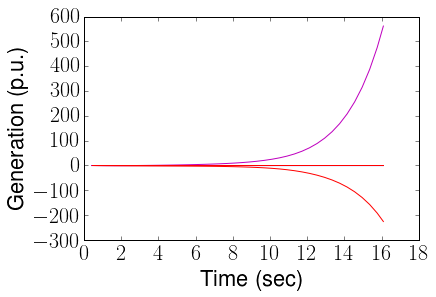

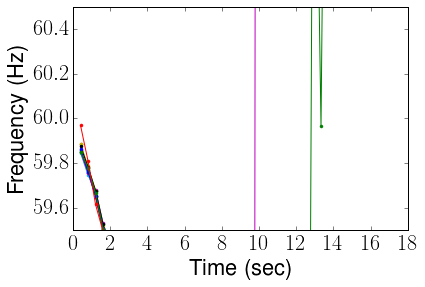

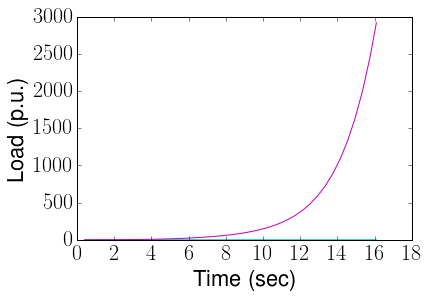

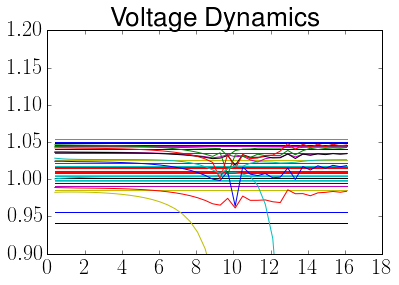

In [31]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 22})
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)
ys_array = np.asarray(ys);
ys_array = np.squeeze(ys_array,axis=2);
print ys_array.shape
import matplotlib.pyplot as plt;

### P_{Mechanical} Generation looks more or less okay
print pmechrange
plt.figure()
plt.plot(ts,ys_array[:,pmechrange])
plt.ylabel('Generation (p.u.)')
plt.xlabel('Time (sec)')
#plt.ylim([-0.5,5.0])

### Valve dynamics (generation control signal) look okay. 
#plt.figure()
#plt.plot(ts,ys_array[:,valverange])
#plt.title('Valve')


### Omega dynamics look DIFFERENT from MATLAB
plt.figure()
plt.plot(ts,60+ys_array[:,omegarange],'.-');

plt.ylim([59.5,60.5])
plt.xlabel('Time (sec)')
plt.ylabel('Frequency (Hz)')
#plt.xlim([0.0,6.0])


### Load dynamics look okay (consistent with MATLAB sims )
plt.figure()
plt.plot(ts,ys_array[:,loadrange]);
#plt.title('Load')
plt.ylabel('Load (p.u.)')
plt.xlabel('Time (sec)');
#plt.ylim([-10.0,10.0]);
plt.show()
plt.figure()

### Voltage dynamics look DIFFERENT from MATLAB
plt.plot(ts,ys_array[:,Erange]);
plt.ylim([0.9,1.2]);
plt.title('Voltage Dynamics')
plt.show()
plt.figure()
